## LSN theoratical toy example
### Quadratic brain ROI trajectories with age

### 1. Additive initial factor: subject variability
### 2. Additive time shift: ROI variability


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from simul import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
                    


## Brain trajectories
### ROI variability: Additive time shift: ROI variability
### Cortical thickness trajectories can start: 2mm, peak: 3mm, thin: 2.5 ([over lifespan](https://pubmed.ncbi.nlm.nih.gov/24948804/))
### Individual differences (std) ~ 0.1mm with smoothing ([source](https://www.pnas.org/content/pnas/97/20/11050.full.pdf))

In [ ]:
n_timepoints = 100
init_val = 2
peak_val = 4
poly_order = 2

traj1_time_shift = 50
traj2_time_shift = 60

traj1 = get_brain_trajectory(n_timepoints,init_val, peak_val, traj1_time_shift,poly_order)
traj2 = get_brain_trajectory(n_timepoints,init_val, peak_val, traj2_time_shift,poly_order)

t = np.arange(n_timepoints)
plt.plot(t,traj1, label="roi-1")
plt.plot(t,traj2, label="roi-2")
plt.xlabel("age")
plt.ylabel("thickness")
plt.legend()

## Generate subject-specific random samples 
### Additive initial factor: subject variability

In [ ]:
# same init factor for each ROI
n_samples = 100
intersubject_std = 0.0

roi_1 = get_traj_samples(traj1, n_samples, intersubject_std)
roi_2 = get_traj_samples(traj2, n_samples, intersubject_std)

palette = 'husl'
sns.set(font_scale=1)

fig, axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
with sns.axes_style("whitegrid"):    
    ax = axes[0]
    g = sns.heatmap(roi_1, ax=ax)
    g.set_xlabel("age")
    g.set_ylabel("sample id")
    g.set_title("ROI-1")
    ax = axes[1]
    g = sns.heatmap(roi_2, ax=ax)
    g.set_title("ROI-2")
    g.set_xlabel("age")

In [ ]:
time_diff = abs(traj1[1:] - traj1[:-1])
indiv_diff = abs(roi_1[:,0][1:] - roi_1[:,0][:-1])

print(f"time_diff mean: {np.mean(time_diff)}, std: {np.std(time_diff)}")
print(f"indiv_diff mean: {np.mean(indiv_diff)}, std: {np.std(indiv_diff)}")

t_df = pd.DataFrame()
i_df = pd.DataFrame()
t_df["diff"] = time_diff
t_df["type"] = "time"
i_df["diff"] = indiv_diff
i_df["type"] = "indiv"
plot_df = t_df.append(i_df)

sns.histplot(x="diff",bins=100,hue="type",data=plot_df)

## Run entire toy example

In [2]:
# Traj params (Fixed)

intercept = 5
poly_order = 2
roi_maturity_min = 30
roi_maturity_max = 70
n_timepoints = 100

init_val = 2 #min thickness
peak_val = 4 #max thickness 

intersubject_std = 0.1 # No variability 

n_samples_list = [10, 100]
n_regions_list = [10, 100, 1000]
followup_list = [2]

data_aug = True

verbose = False
n_jobs = 4

perf_df = pd.DataFrame()

for followup_interval in followup_list:
    for n_samples in n_samples_list:
        for n_regions in n_regions_list: 

            # Model configs (need to initialized for each data config)
            model_dict = {
                "Ridge": Ridge(), 
                "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1), 
                # "GB": GradientBoostingRegressor(random_state=1)
                "LSN": None,
                # "LSN1": None,
                # # "LSN2": None,
                # "LSN3": None
            }

            # Region values are shifted in time
            time_shift_list = np.linspace(start=roi_maturity_min,stop=roi_maturity_max,num=n_regions)

            # Get traj(s): subject values are shifted in intercept
            traj_list = [get_brain_trajectory(n_timepoints, init_val, peak_val, time_shift, poly_order) for time_shift in time_shift_list]

            # Get roi samples
            roi_list = [get_traj_samples(traj, n_samples, intersubject_std) for traj in traj_list]

            # Get cross-sectional time data (sample with replacement)
            y_baseline, X_baseline, X_followup = get_cross_sectional_samples(roi_list, followup_interval=followup_interval)

            # normalize y
            y_followup = y_baseline + followup_interval
            y_baseline = y_baseline/100
            y_followup = y_followup/100

            if followup_interval > 0:                
                X = np.hstack([X_baseline,X_followup])
                y = np.vstack([y_baseline,y_followup]).T
            else:
                X = X_baseline
                y = y_baseline
                
            # Split for CV and held-out test set
            n_CV = int(0.75 * len(y))
            
            X_CV = X[:n_CV]
            X_test = X[n_CV:]
            y_CV = y[:n_CV]
            y_test = y[n_CV:]

            if data_aug:
                print("Augmenting data (4x) using combinations")
                X_baseline_CV = X_baseline[:n_CV]
                X_followup_CV = X_followup[:n_CV]
                y_baseline_CV = y_baseline[:n_CV]
                y_followup_CV = y_followup[:n_CV]
                
                X_orig = np.hstack([X_baseline_CV,X_followup_CV])
                y_orig = np.vstack([y_baseline_CV,y_followup_CV]).T
                
                # swap timepoints
                X_swap = np.hstack([X_followup_CV, X_baseline_CV])
                y_swap = np.vstack([y_followup_CV, y_baseline_CV]).T
                
                # # baseline only
                X_base = np.hstack([X_baseline_CV, X_baseline_CV])
                y_base = np.vstack([y_baseline_CV, y_baseline_CV]).T

                # followup only
                X_follow = np.hstack([X_followup_CV, X_followup_CV])
                y_follow = np.vstack([y_followup_CV, y_followup_CV]).T

                X_CV = np.vstack([X_orig,X_swap])
                y_CV = np.vstack([y_orig,y_swap])

                # X_CV = np.vstack([X_orig,X_swap,X_base,X_follow])
                # y_CV = np.vstack([y_orig,y_swap,y_base,y_follow])


            if verbose:
                print(f"CV data shapes, X:{X_CV.shape}, y:{y_CV.shape}")
                print(f"CV data means, X: {np.mean(X_CV):3.2f}, y:{np.mean(y_CV):3.2f}")

                print(f"test data shapes, X:{X_test.shape}, y:{y_test.shape}")
                print(f"test data means, X: {np.mean(X_test):3.2f}, y:{np.mean(y_test):3.2f}")

            # Run Models
            for model_name, model_instance in model_dict.items():
                print(f"\nSim config: n_samples: {n_samples}, n_regions= {n_regions}, followup: {followup_interval}, model: {model_name}")
                if model_name in ["LSN","LSN1","LSN2","LSN3"]:
                    # train
                    batch_size = 5

                    if model_name == "LSN1":
                        hidden_size = 10
                    elif model_name == "LSN2":
                        hidden_size = 50
                    elif model_name == "LSN3":
                        hidden_size = 100
                    else:
                        hidden_size = 25
                    
                    train_dataset = SimDataset(X_CV[:,:n_regions], X_CV[:,n_regions:], y_CV[:,0], y_CV[:,1])
                    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                
                    model = LSN(X_baseline.shape[1],hidden_size=hidden_size) # alternative toy model: LSN()

                    model = torch.nn.DataParallel(model)
                        
                    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
                    criterion = nn.MSELoss()
                    n_epochs = 500

                    model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
                    
                    # test
                    test_dataset = SimDataset(X_test[:,:n_regions], X_test[:,n_regions:], y_test[:,0], y_test[:,1])
                    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

                    model.eval()                    
                    batch_pred_list, loss1_list, loss2_list = test(model, test_dataloader)
                    batch_pred_array = np.vstack(np.squeeze(batch_pred_list))
                    
                    r1 = stats.pearsonr(batch_pred_array[:,0],y_test[:,0])[0]
                    r2 = stats.pearsonr(batch_pred_array[:,1],y_test[:,1])[0]
                    
                    df = pd.DataFrame()
                    df["eid"] = np.arange(len(y_test))
                    df["test_age_1"] = 100*y_test[:,0]
                    df["test_age_2"] = 100*y_test[:,1]
                    df["test_brainage_1"] = batch_pred_array[:,0]
                    df["test_brainage_2"] = batch_pred_array[:,1]
                    df["test_MAE1"] = loss1_list
                    df["test_MAE2"] = loss2_list
                    df["test_r1"] = r1
                    df["test_r2"] = r2
                    df["CV_score"] = epoch_loss_df["epoch_loss"].values[-1]
                    df["model"] = model_name
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval                   
                    
                    perf_df = perf_df.append(df)

                else:
                    CV_scores, y_pred, test_MAE1, test_MAE2, test_r1, test_r2 = get_brain_age_perf(X_CV, y_CV, X_test, y_test, model_instance)
                
                    df = pd.DataFrame()
                    df["eid"] = np.arange(len(y_test))
                    df["test_age_1"] = 100*y_test[:,0]
                    df["test_age_2"] = 100*y_test[:,1]
                    df["test_brainage_1"] = y_pred[:,0]
                    df["test_brainage_2"] = y_pred[:,1]
                    df["test_MAE1"] = test_MAE1                    
                    df["test_MAE2"] = test_MAE2
                    df["test_r1"] = test_r1
                    df["test_r2"] = test_r2
                    df["CV_score"] = np.mean(-1*CV_scores) #negative MSE
                    df["model"] = model_name
                    df["n_samples"] = n_samples
                    df["n_regions"] = n_regions
                    df["followup_interval"] = followup_interval                    
                    perf_df = perf_df.append(df)

Augmenting data (4x) using combinations

Sim config: n_samples: 10, n_regions= 10, followup: 2, model: Ridge

Sim config: n_samples: 10, n_regions= 10, followup: 2, model: RF

Sim config: n_samples: 10, n_regions= 10, followup: 2, model: LSN
epoch 499 loss: 0.0071
Augmenting data (4x) using combinations

Sim config: n_samples: 10, n_regions= 100, followup: 2, model: Ridge

Sim config: n_samples: 10, n_regions= 100, followup: 2, model: RF

Sim config: n_samples: 10, n_regions= 100, followup: 2, model: LSN
epoch 499 loss: 0.0035
Augmenting data (4x) using combinations

Sim config: n_samples: 10, n_regions= 1000, followup: 2, model: Ridge

Sim config: n_samples: 10, n_regions= 1000, followup: 2, model: RF

Sim config: n_samples: 10, n_regions= 1000, followup: 2, model: LSN
epoch 499 loss: 0.0053
Augmenting data (4x) using combinations

Sim config: n_samples: 100, n_regions= 10, followup: 2, model: Ridge

Sim config: n_samples: 100, n_regions= 10, followup: 2, model: RF

Sim config: n_samp

In [3]:
print(f"perf df shape: {perf_df.shape}, expected: {0.25*np.sum(n_samples_list)*len(model_dict)*len(n_regions_list)*len(followup_list)}")
print(perf_df.groupby(["model"])["test_age_1"].max())
perf_df.head()

perf df shape: (2502, 14), expected: 2497.5
model
LSN      97.0
RF       97.0
Ridge    97.0
Name: test_age_1, dtype: float64


,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_MAE1,test_MAE2,test_r1,test_r2,CV_score,model,n_samples,n_regions,followup_interval
0,0,41.0,43.0,39.796267,41.796267,1.203733,1.203733,0.999995,0.999995,0.007445,Ridge,10,10,2
1,1,60.0,62.0,59.862942,61.862942,0.137058,0.137058,0.999995,0.999995,0.007445,Ridge,10,10,2
2,2,51.0,53.0,50.303787,52.303787,0.696213,0.696213,0.999995,0.999995,0.007445,Ridge,10,10,2
0,0,41.0,43.0,42.070000,44.070000,1.070000,1.070000,0.430451,0.430451,0.055730,RF,10,10,2
1,1,60.0,62.0,44.080000,46.080000,15.920000,15.920000,0.430451,0.430451,0.055730,RF,10,10,2


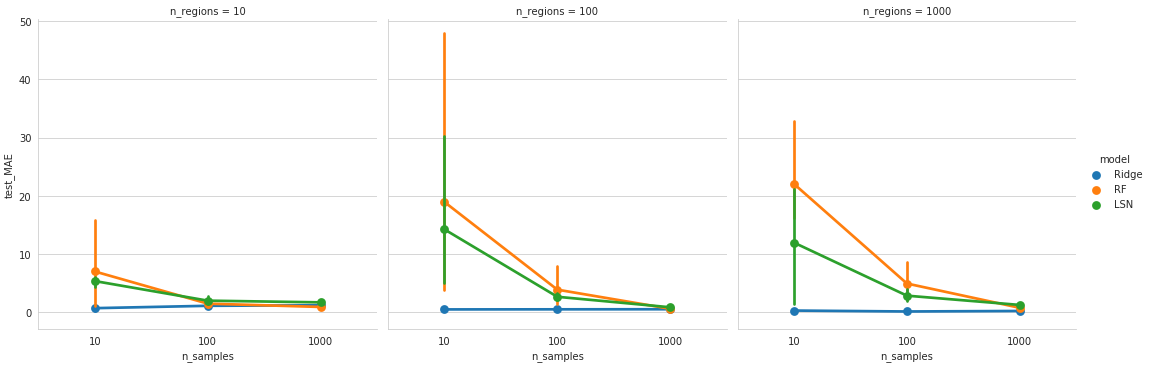

In [4]:
plot_df = perf_df[perf_df["followup_interval"]==2].copy()
plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["test_r"] = 0.5 * (plot_df["test_r1"] +plot_df["test_r1"])

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="n_regions", kind="point", data=plot_df, aspect=1)

In [5]:
# perf_df.to_csv("results/simulation/brain_diff_sim_twinmodels_run_1.csv")
# 
# LSN_df = pd.read_csv("results/simulation/brain_diff_sim_LSN_run_1.csv")
# base_df = pd.read_csv("results/simulation/brain_diff_sim_basemodels_run_2.csv")
# LSN_df = perf_df.copy()

epoch_loss_df

,epoch_loss
0,0.333044
1,0.332890
2,0.177815
3,0.166789
4,0.165874
...,...
495,0.000978
496,0.001029
497,0.000940
498,0.001016


## Plots

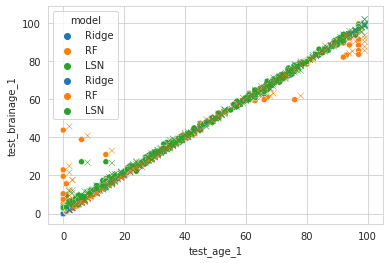

In [6]:
plot_df = perf_df[(perf_df["followup_interval"]==2)&(perf_df["n_regions"]==1000)].copy()

with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x="test_age_1",y="test_brainage_1",hue="model", marker="o", data=plot_df)
    g = sns.scatterplot(x="test_age_2",y="test_brainage_2",hue="model", marker="x", data=plot_df)

## Brain age: (followup - baseline)

In [12]:
plot_df = perf_df.copy()
plot_df["age_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df.groupby(["model","n_samples","n_regions"])["test_MAE","age_diff"].mean()

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


test_MAE  age_diff
model n_samples n_regions                     
LSN   10        10          5.338799  3.282758
                100        14.229459  2.336992
                1000       11.946070 -0.206727
      100       10          1.967884  1.748780
                100         2.633457  1.700205
                1000        2.826405  2.163299
      1000      10          1.675922  2.121055
                100         0.828983  2.006444
                1000        1.229625  1.919698
RF    10        10          6.986667  2.000000
                100        18.940000  2.000000
                1000       22.040000  2.000000
      100       10          1.456000  2.000000
                100         3.859200  2.000000
                1000        4.913600  2.000000
      1000      10          0.885320  2.000000
                100         0.565760  2.000000
                1000        0.733240  2.000000
Ridge 10        10          0.679001  2.000000
                100         0.462518  2.000000
                1000        0.265596  2.000000
      100       10          1.083760  2.000000
                100         0.478872  2.000000
                1000        0.106968  2.000000
      1000      10          1.173922  2.000000
                100         0.492858  2.000000
                1000        0.194812  2.000000

In [10]:
perf_df

,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_MAE1,test_MAE2,test_r1,test_r2,CV_score,model,n_samples,n_regions,followup_interval
0,0,41.0,43.0,39.796267,41.796267,1.203733,1.203733,0.999995,0.999995,0.007445,Ridge,10,10,2
1,1,60.0,62.0,59.862942,61.862942,0.137058,0.137058,0.999995,0.999995,0.007445,Ridge,10,10,2
2,2,51.0,53.0,50.303787,52.303787,0.696213,0.696213,0.999995,0.999995,0.007445,Ridge,10,10,2
0,0,41.0,43.0,42.070000,44.070000,1.070000,1.070000,0.430451,0.430451,0.055730,RF,10,10,2
1,1,60.0,62.0,44.080000,46.080000,15.920000,15.920000,0.430451,0.430451,0.055730,RF,10,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,57.0,59.0,56.059200,57.941532,0.940800,1.058464,0.999220,0.999210,0.001052,LSN,1000,1000,2
246,246,75.0,77.0,75.469307,77.238464,0.469307,0.238464,0.999220,0.999210,0.001052,LSN,1000,1000,2
247,247,72.0,74.0,73.039886,74.930855,1.039886,0.930855,0.999220,0.999210,0.001052,LSN,1000,1000,2
248,248,7.0,9.0,8.679780,10.583064,1.679780,1.583064,0.999220,0.999210,0.001052,LSN,1000,1000,2
